In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [4]:
!kaggle datasets download -d khoongweihao/covid19-xray-dataset-train-test-sets

Dataset URL: https://www.kaggle.com/datasets/khoongweihao/covid19-xray-dataset-train-test-sets
License(s): CC0-1.0
 83% 70.0M/84.3M [00:00<00:00, 171MB/s]
100% 84.3M/84.3M [00:00<00:00, 170MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/CV/tubrculosis.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
print ('Modules loaded')

Modules loaded


In [7]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):

    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True)
    return

msg='test of default colors'
print_in_color(msg)

test of default colors



In [8]:

def make_dataframes(sdir):
    filepaths=[]
    labels=[]
    classlist=sorted(os.listdir(sdir) )
    for klass in classlist:
        classpath=os.path.join(sdir, klass)
        if os.path.isdir(classpath):
            flist=sorted(os.listdir(classpath))
            desc=f'{klass:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)
    train_df, dummy_df=train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)

    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)
    counts=list(train_df['labels'].value_counts())
    print(counts[0], type(counts[0]))
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
    return train_df, test_df, valid_df, classes, class_count

sdir=r'/content/TB_Chest_Radiography_Database'
train_df, test_df, valid_df, classes, class_count=make_dataframes(sdir)

Tuberculosis             : 100%|█████████████████████████████████████████████████████████| 700/700 [00:00<00:00, 469311.51files/s]


number of classes in processed dataset=  2
2800 <class 'int'>
the maximum files in any class in train_df is  2800   the minimum files in any class in train_df is  560
train_df length:  3360   test_df length:  420   valid_df length:  420
average image height=  512   average image width=  512  aspect ratio h/w=  1.0


In [9]:

def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()
    class_count=len(classes)
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples=500
min_samples=500
column='labels'
train_df, classes, class_count=trim(train_df, max_samples, min_samples, column)

dataframe initially is of length  3360  with  2  classes
after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  500
the trimmed dataframe now is of length  1000  with  2  classes


In [10]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path)

    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels')
    for label in df['labels'].unique():
        group=groups.get_group(label)
        sample_count=len(group)
        if sample_count< n:
            aug_img_count=0
            delta=n - sample_count
            target_dir=os.path.join(aug_dir, label)
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='')
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)

    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

In [11]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator()
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='')
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='')
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='')
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps

img_size=(224,224)
batch_size =30
train_gen, test_gen, valid_gen, test_steps =make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 1000 validated image filenames belonging to 2 classes.
Found 420 validated image filenames belonging to 2 classes.
Found 420 validated image filenames belonging to 2 classes.
test batch size:  70   test steps:  6  number of classes :  2


In [17]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen)
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<10:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )

Output hidden; open in https://colab.research.google.com to view.

In [18]:
import zipfile
zip_ref = zipfile.ZipFile('/content/covid19-xray-dataset-train-test-sets.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [19]:
train_dir = '/content/xray_dataset_covid19/train'
test_dir ='/content/xray_dataset_covid19/test'

In [20]:
train_images=[]
train_labels=[]
test_images=[]
test_labels=[]

In [21]:
def load_images_from_directory(directory, label, images_list, labels_list):
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):

                file_path = os.path.join(dirname, filename)


                img = cv2.imread(file_path)

                if img is None:
                    print(f"Warning: Unable to read image {file_path}")
                    continue


                img = cv2.resize(img, (64, 64))


                img = img / 255.0


                images_list.append(img)
                labels_list.append(label)


load_images_from_directory(os.path.join(train_dir, 'NORMAL'), 0, train_images, train_labels)
load_images_from_directory(os.path.join(train_dir, 'PNEUMONIA'), 1, train_images, train_labels)


load_images_from_directory(os.path.join(test_dir, 'NORMAL'), 0, test_images, test_labels)
load_images_from_directory(os.path.join(test_dir, 'PNEUMONIA'), 1, test_images, test_labels)

print(f"Train images shape: {np.array(train_images).shape}")
print(f"Train labels shape: {np.array(train_labels).shape}")
print(f"Test images shape: {np.array(test_images).shape}")
print(f"Test labels shape: {np.array(test_labels).shape}")

Train images shape: (148, 64, 64, 3)
Train labels shape: (148,)
Test images shape: (40, 64, 64, 3)
Test labels shape: (40,)


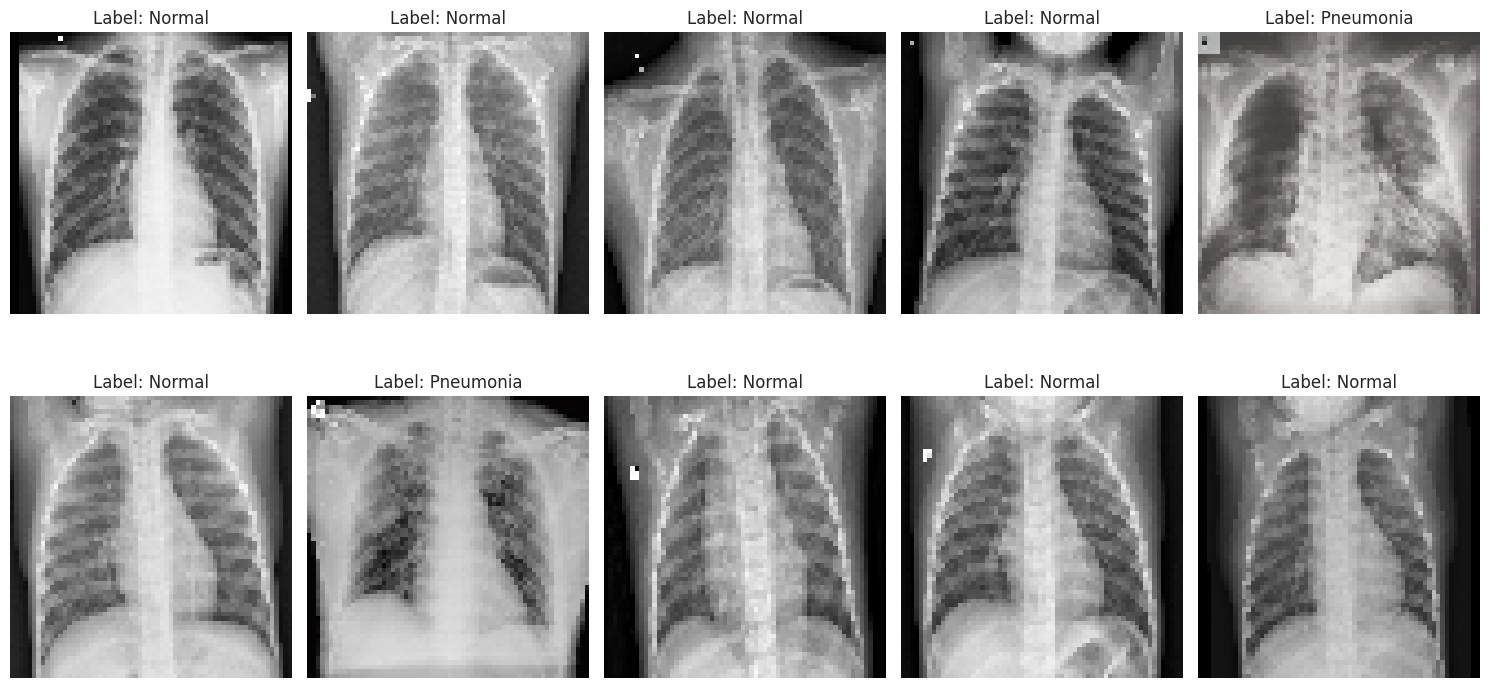

In [22]:
import random
random_indices = random.sample(range(len(train_images)), 10)

plt.figure(figsize=(15, 8))

for i, idx in enumerate(random_indices, 1):
    plt.subplot(2, 5, i)
    plt.imshow(train_images[idx])
    plt.title(f"Label: {'Pneumonia' if train_labels[idx] == 1 else 'Normal'}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [23]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)


train_images_flattened = train_images.reshape(train_images.shape[0], -1)
test_images_flattened = test_images.reshape(test_images.shape[0], -1)


label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(train_images_flattened, train_labels_encoded, test_size=0.2, random_state=42)


svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

y_val_pred = svm_model.predict(X_val)
print("Validation accuracy: ", accuracy_score(y_val, y_val_pred))
print("Classification report:\n", classification_report(y_val, y_val_pred))

y_test_pred = svm_model.predict(test_images_flattened)
print("\nTest accuracy: ", accuracy_score(test_labels_encoded, y_test_pred))
print("Test Classification report:\n", classification_report(test_labels_encoded, y_test_pred))


Validation accuracy:  1.0
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Test accuracy:  0.975
Test Classification report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



In [26]:
y_pred = svm_model.predict(test_images_flattened)

random_indices = random.sample(range(len(test_images)), 10)

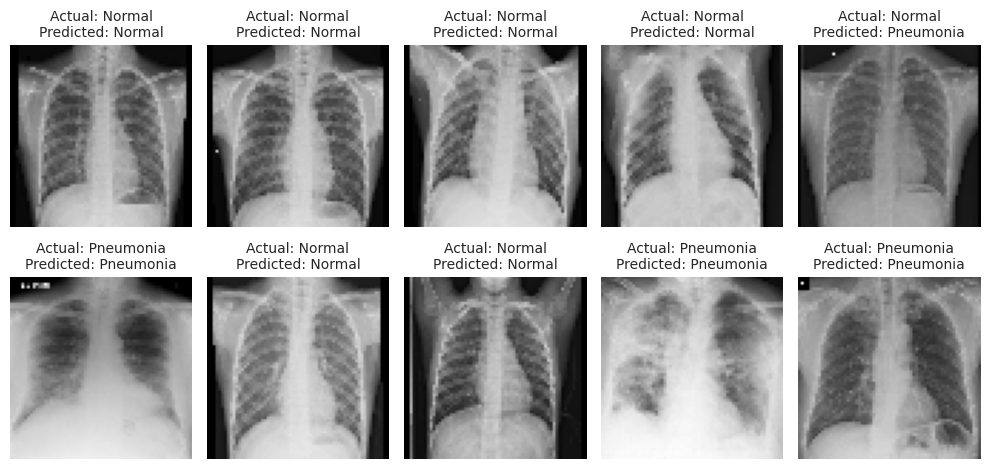

In [27]:
plt.figure(figsize=(10, 5))

for i, idx in enumerate(random_indices, 1):
    plt.subplot(2, 5, i)
    plt.imshow(test_images[idx])


    actual_label = 'Pneumonia' if test_labels[idx] == 1 else 'Normal'
    predicted_label = 'Pneumonia' if y_pred[idx] == 1 else 'Normal'

    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from flask import Flask, render_template, request, send_from_directory
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

app = Flask(__name__)

@app.route('/')
def index():
    return render_template('home.html')


@app.route('/upload', methods=['POST'])
def upload_file():
    if 'file' not in request.files:
        return "No file part"
    file = request.files['file']
    if file.filename == '':
        return "No selected file"

    if file:

        temp_filepath = '/content/drive/MyDrive/Hackathon/sample11.jpg'
        file.save(temp_filepath)

        try:

            img = cv2.imread(temp_filepath)
            if img is None:
                return "Error: Could not read the uploaded image."
            img = cv2.resize(img, (224, 224))
            img = np.expand_dims(img, axis=0)
            img = img / 255.0


            prediction = model.predict(img)
            result = np.argmax(prediction, axis=1)


            if result == 0:
                prediction_result = "Tuberculosis Detected"
            elif result == 1:
                prediction_result = "COVID Detected"
            else:
                prediction_result = "Unable to determine"


            os.remove(temp_filepath)

            return render_template('home.html', prediction=prediction_result)

        except Exception as e:

            os.remove(temp_filepath)
            return f"Error during prediction: {str(e)}"


@app.route('/favicon.ico')
def favicon():
    return send_from_directory(os.path.join(app.root_path, 'static'),
                               'favicon.ico', mimetype='image/vnd.microsoft.icon')

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
